In [0]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
!tar -xvzf genres.tar.gz
!mv genres Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r Dataset '/content/drive/My Drive'

In [0]:
import pandas as pd
import numpy as np
from tqdm import trange
import os 
import librosa
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.backend import one_hot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

## Process data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
genres=['classical', 'jazz', 'pop', 'reggae', 'hiphop', 'country', 'metal', 'blues', 'rock', 'disco']
Data_meta=[]
for idx,i in enumerate(genres):
    path='/content/drive/My Drive/Dataset/'+i+'/'
    for a,b,c in os.walk(path):
      for x in c: 
        Data_meta.append((path+x,idx,i))

Data_meta = pd.DataFrame(Data_meta,columns=['path','label','Label'])
Data_meta.head()

,path,label,Label
0,/content/drive/My Drive/Dataset/classical/clas...,0,classical
1,/content/drive/My Drive/Dataset/classical/clas...,0,classical
2,/content/drive/My Drive/Dataset/classical/clas...,0,classical
3,/content/drive/My Drive/Dataset/classical/clas...,0,classical
4,/content/drive/My Drive/Dataset/classical/clas...,0,classical


In [0]:
!mkdir '/content/drive/My Drive/Dataset/noised'

In [12]:
y, sr = librosa.load(Data_meta.iloc[42]['path'], sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print(mfccs.T.shape,y.shape,sr)

(1308, 40) (669680,) 22050


## Data Argumentation

### Add noise

In [0]:
def add_noise(data):
  wn = np.random.normal(0, 1, len(data))
  data_noise = np.where(data != 0.0, data.astype('float64') + 0.02 * wn, 0.0).astype(np.float32)
  return data_noise
  

In [0]:
n=len(Data_meta)
for i in trange(n):
  y, sr = librosa.load(Data_meta.iloc[i]['path'], sr=None)
  y_noise = add_noise(y)  
  path='/content/drive/My Drive/Dataset/noised/noised_%d.wav'%i
  librosa.output.write_wav(path, y_noise, sr)
  Data_meta=Data_meta.append({'path':path,'label':Data_meta.iloc[i]['label'],'Label':Data_meta.iloc[i]['Label']},ignore_index=True)
Data_meta.tail()

100%|██████████| 1100/1100 [03:43<00:00,  4.91it/s]


,path,label,Label
2195,/content/drive/My Drive/Dataset/noised/noised_...,9,disco
2196,/content/drive/My Drive/Dataset/noised/noised_...,9,disco
2197,/content/drive/My Drive/Dataset/noised/noised_...,9,disco
2198,/content/drive/My Drive/Dataset/noised/noised_...,9,disco
2199,/content/drive/My Drive/Dataset/noised/noised_...,9,disco


### Save as csv file

In [0]:
print(Data_meta.iloc[12]['path'])
Data_meta.head()
Data_meta.to_csv('/content/drive/My Drive/Dataset/Datameta.csv')

/content/drive/My Drive/Dataset/classical/classical.00012.wav


In [0]:
ls

bextract_single.mf  cl.mf         di.mf    input.mf  metal/   pop/     ro.mf
bl.mf               co.mf         disco/   ja.mf     noise/   reggae/
blues/              country/      hi.mf    jazz/     noised/  re.mf
classical/          Datameta.csv  hiphop/  me.mf     po.mf    rock/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data

In [0]:
genres=['classical', 'jazz', 'pop', 'reggae', 'hiphop', 'country', 'metal', 'blues', 'rock', 'disco']
Data_meta=pd.read_csv('/content/drive/My Drive/Dataset/Datameta.csv')

In [11]:
def load_data(Data_meta,n):
  x, sr = librosa.load(Data_meta.iloc[0]['path'], sr=None)
  x=x[:n]
  X=x
  Y=np.array(one_hot(Data_meta.iloc[0]['label'],len(genres)))
  for i in trange(1,len(Data_meta)):
    x, sr = librosa.load(Data_meta.iloc[i]['path'], sr=None)
    x=x[:n]
    y=one_hot(Data_meta.iloc[i]['label'],len(genres))
    X=np.dstack((X,x))
    Y=np.vstack((Y,y))
  

  return X.T,Y

#X,Y=load_data(Data_meta,660000)#660000
#yprint(X.shape,Y.shape)



  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 1/1999 [00:00<04:55,  6.77it/s]

  0%|          | 2/1999 [00:00<05:01,  6.63it/s]

  0%|          | 3/1999 [00:00<05:05,  6.53it/s]

  0%|          | 4/1999 [00:00<05:09,  6.44it/s]

  0%|          | 5/1999 [00:00<05:13,  6.36it/s]

  0%|          | 6/1999 [00:00<05:13,  6.35it/s]

  0%|          | 7/1999 [00:01<05:17,  6.27it/s]

  0%|          | 8/1999 [00:01<05:19,  6.24it/s]

  0%|          | 9/1999 [00:01<05:18,  6.25it/s]

  1%|          | 10/1999 [00:01<05:22,  6.17it/s]

  1%|          | 11/1999 [00:01<05:28,  6.05it/s]

  1%|          | 12/1999 [00:01<05:28,  6.05it/s]

  1%|          | 13/1999 [00:02<05:33,  5.96it/s]

  1%|          | 14/1999 [00:02<05:31,  5.98it/s]

  1%|          | 15/1999 [00:02<05:31,  5.99it/s]

  1%|          | 16/1999 [00:02<05:29,  6.02it/s]

  1%|          | 17/1999 [00:02<05:34,  5.92it/s]

  1%|          | 18/1999 [00:02<05:31,  5.97it/s]

  1%|          | 19/1999 [00:03<05:39,  5.83it/

(2000, 660000, 1) (2000, 10)


In [0]:
#np.savez('raw_data.npz',X_raw=X,Y_raw=Y)

In [0]:
#!cp raw_data.npz '/content/drive/My Drive/Dataset'

In [3]:
raw_data = np.load('/content/drive/My Drive/Dataset/raw_data.npz')
X_raw=np.squeeze(raw_data['X_raw'])
Y_raw=raw_data['Y_raw']
print(X_raw.shape,Y_raw.shape)

(2000, 660000) (2000, 10)


### Splitting songs

In [0]:
def extract_mfcc(x,sr):
  mfccs = librosa.feature.mfcc(y=x[0], sr=sr, n_mfcc=40)
  X=mfccs
  for i in trange(1,x.shape[0]):
    mfccs = librosa.feature.mfcc(y=x[i], sr=sr, n_mfcc=40)
    X = np.dstack((X,mfccs))
  return X.T

In [0]:
def splitSongs(X, Y, window, overlap):
  temp_X = []
  temp_Y = []
  for j in trange(X.shape[0]):
    temp = X[j]
    xshape = temp.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.0-overlap))
    #spltSongs=librosa.util.frame(temp, frame_length=chunk, hop_length=offset)##要求内存连续，colab会炸
    spltSongs = [temp[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spltSongs:      
      if s.shape[0] == chunk:
        temp_X.append(s)
        temp_Y.append(Y[j])
  print("after",np.array(temp_X).shape)
  return np.array(temp_X), np.array(temp_Y)

In [0]:
def shuffle(X,Y):
  index = np.random.permutation(X.shape[0])
  Y = np.array(Y)
  return X[index],Y[index]

In [7]:
X_split,Y= splitSongs(X_raw,Y_raw, 0.1, 0.5)

100%|██████████| 2000/2000 [00:00<00:00, 51284.83it/s]


after (38000, 66000)


In [8]:
X = extract_mfcc(X_split,22050)
print(X.shape,Y.shape)

100%|██████████| 37999/37999 [3:03:17<00:00,  3.46it/s]

(38000, 129, 40) (38000, 10)


In [0]:
np.savez('splitted_mfccs.npz',X_=X,Y_=Y)

In [0]:
!cp splitted_mfccs.npz '/content/drive/My Drive/Dataset'

In [0]:
MFFCS=np.load('/content/drive/My Drive/Dataset/splitted_mfccs.npz')
X=MFFCS['X_']
Y=MFFCS['Y_']

In [0]:
X,Y=shuffle(X,Y)
N=X.shape[0]
X_train,Y_train = X[:3*N//5],Y[:3*N//5]
X_val,Y_val = X[3*N//5:4*N//5],Y[3*N//5:4*N//5]
X_test,Y_test = X[4*N//5:],Y[4*N//5:]

## Build NN

In [0]:
def conv(x, n_kernel, pool_size=(2, 2)):
    x = Conv2D(n_kernel, (3, 3), strides=(1, 1), padding='same',data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [0]:
def get_model(input_dim,output_dim,penalty):

    IN = Input(shape=(input_dim[0],input_dim[1],1))
    x = conv(IN, 16)
    x = conv(x, 32)
    x = conv(x, 64)
    x = conv(x, 128)
    x = conv(x, 256)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(penalty))(x)
    x = Dropout(0.25)(x)
    pred = Dense(output_dim, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    print("pred",pred)
    model = Model(inputs=IN, outputs=pred)
    return model

In [15]:
# model = get_model(X[-1].shape,10,1e-4)
model = get_model(X_train[-1].shape,10,1e-4) # -------------------Changed 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())

pred Tensor("dense_1/Identity:0", shape=(None, 10), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 40, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 129, 40, 16)       160       
_________________________________________________________________
activation (Activation)      (None, 129, 40, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 20, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 20, 32)        4640      
____________________________________________________________

In [16]:
history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(X_val, Y_val))

Epoch 1/100
357/357 [==============================] - 4s 12ms/step - loss: 2.2785 - accuracy: 0.2871 - val_loss: 1.8822 - val_accuracy: 0.4246
Epoch 2/100
357/357 [==============================] - 4s 10ms/step - loss: 1.6352 - accuracy: 0.4801 - val_loss: 1.4126 - val_accuracy: 0.5989
Epoch 3/100
357/357 [==============================] - 4s 10ms/step - loss: 1.3705 - accuracy: 0.5695 - val_loss: 1.3028 - val_accuracy: 0.6025
Epoch 4/100
357/357 [==============================] - 4s 10ms/step - loss: 1.2109 - accuracy: 0.6200 - val_loss: 1.1071 - val_accuracy: 0.6570
Epoch 5/100
357/357 [==============================] - 4s 10ms/step - loss: 1.0925 - accuracy: 0.6579 - val_loss: 0.9904 - val_accuracy: 0.7162
Epoch 6/100
357/357 [==============================] - 4s 10ms/step - loss: 1.0140 - accuracy: 0.6882 - val_loss: 0.9180 - val_accuracy: 0.7279
Epoch 7/100
357/357 [==============================] - 4s 11ms/step - loss: 0.9427 - accuracy: 0.7069 - val_loss: 0.8971 - val_accuracy:

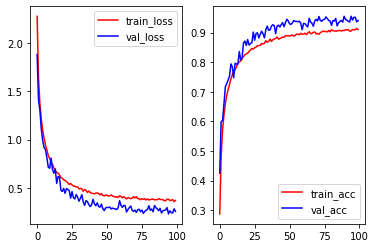

In [17]:
fig,ax=plt.subplots(ncols=2)
#fig.suptitle("epochs=%d  $\lambda$=%f lr=%f batch_size=%d"%(epochs,self.lamda,lr,batch_size))
ax[0].plot(history.history['loss'],label='train_loss',color='r')
ax[0].plot(history.history['val_loss'],label='val_loss',color='b')
ax[0].legend()
ax[1].plot(history.history['accuracy'],label='train_acc',color='r')
ax[1].plot(history.history['val_accuracy'],label='val_acc',color='b')
ax[1].legend()
plt.show()


In [18]:
print(model.evaluate(X_test,Y_test))

238/238 [==============================] - 1s 4ms/step - loss: 0.2699 - accuracy: 0.9437
[0.2699023485183716, 0.9436842203140259]
